In [36]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import StratifiedKFold

%matplotlib inline
plt.rcParams['figure.figsize'] =  (17.0, 4.0) #Default (6.0, 4.0)

In [37]:
# TODO
# (0) Select the best [N, 2N] data points. At least N and then remaining N if they are above the FPR_TARGET level
# (1) Incorporate into the general framework
# (2) Combine model predictions for ensemble / voting framework
# (3) Add more classification models

In [38]:
# ----------------------------------------------------
# Get data
# ----------------------------------------------------
np.random.seed(15)
X, y = make_classification(n_samples=10000) #80000
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1) # test is only to be used at the very end!

In [39]:
# ----------------------------------------------------
# User defined
# ----------------------------------------------------
FPR_TARGET = 0.02

In [40]:
# ----------------------------------------------------
# Result objects
# ----------------------------------------------------
roc_results = {} # NAME: [FPR-stats, TPR-stats]
fpr_results = {} # NAME: [matrix of FPR-stats]
thresh_min_results = {} # NAME: thresh_min

In [41]:
def roc_curve_interp(y_test_in, y_pred_in, thresh_standard):
    fpr, tpr, thresh = roc_curve(y_test_in, y_pred_in)
    fpr_interp = np.interp(thresh_standard, thresh, fpr, period=360)
    tpr_interp = np.interp(thresh_standard, thresh, tpr, period=360)
    return fpr_interp, tpr_interp

def add_to_results(fpr, tpr, name, roc_results, fpr_results):
    roc_results[name] = [fpr, tpr]
    if not(name in fpr_results.keys()): fpr_results[name] = fpr
    else: fpr_results[name] = np.vstack([fpr_results[name], fpr])
    return roc_results, fpr_results

In [42]:

def classification_models(y_train_cv, X_train_cv, y_test_cv, X_test_cv, 
                          roc_results, fpr_results, thresh_standard, TORECORD):
    # for random classifiers
    n_estimator = 11 # TODO: can be tuned using CV. When we want to optimize
    
    # for results
    y_pred_results = {}

    # It is important to train the ensemble of trees on a different subset
    # of the training data than the linear regression model to avoid
    # overfitting, in particular if the total number of leaves is
    # similar to the number of training samples
    X_train_cv_small, X_train_lr, y_train_cv_small, y_train_lr = train_test_split(X_train_cv,
                                                                                  y_train_cv,
                                                                                  test_size=0.5)

    # Unsupervised transformation based on totally random trees
    rt = RandomTreesEmbedding(max_depth=3, n_estimators=n_estimator,random_state=0)

    rt_lm = LogisticRegression()
    pipeline = make_pipeline(rt, rt_lm)
    pipeline.fit(X_train_cv_small, y_train_cv_small)
    y_pred_rt = pipeline.predict_proba(X_test_cv)[:, 1]
    y_pred_results['RT + LR'] = y_pred_rt
    if TORECORD:
        fpr_rt_lm, tpr_rt_lm = roc_curve_interp(y_test_cv, y_pred_rt, thresh_standard)
        roc_results, fpr_results = add_to_results(fpr_rt_lm, tpr_rt_lm, 'RT + LR', roc_results, fpr_results)

    # Supervised transformation based on random forests
    rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
    rf_enc = OneHotEncoder()
    rf_lm = LogisticRegression()
    rf.fit(X_train_cv_small, y_train_cv_small)
    rf_enc.fit(rf.apply(X_train_cv_small))
    rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

    y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test_cv)))[:, 1]
    y_pred_results['RF + LR'] = y_pred_rf_lm
    if TORECORD:
        fpr_rf_lm, tpr_rf_lm = roc_curve_interp(y_test_cv, y_pred_rf_lm, thresh_standard)
        roc_results, fpr_results = add_to_results(fpr_rf_lm, tpr_rf_lm, 'RF + LR', roc_results, fpr_results)


    # Supervised transformation based on gradient boosting
    grd = GradientBoostingClassifier(n_estimators=n_estimator)
    grd_enc = OneHotEncoder()
    grd_lm = LogisticRegression()
    grd.fit(X_train_cv_small, y_train_cv_small)
    grd_enc.fit(grd.apply(X_train_cv_small)[:, :, 0])
    grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

    y_pred_grd_lm = grd_lm.predict_proba(
        grd_enc.transform(grd.apply(X_test_cv)[:, :, 0]))[:, 1]
    y_pred_results['GBT + LR'] = y_pred_grd_lm
    if TORECORD:
        fpr_grd_lm, tpr_grd_lm = roc_curve_interp(y_test_cv, y_pred_grd_lm, thresh_standard)
        roc_results, fpr_results = add_to_results(fpr_grd_lm, tpr_grd_lm, 'GBT + LR', roc_results, fpr_results)

    # The gradient boosted model by itself
    y_pred_grd = grd.predict_proba(X_test_cv)[:, 1]
    y_pred_results['GBT'] = y_pred_grd
    if TORECORD:
        fpr_grd, tpr_grd = roc_curve_interp(y_test_cv, y_pred_grd, thresh_standard)
        roc_results, fpr_results = add_to_results(fpr_grd, tpr_grd, 'GBT', roc_results, fpr_results)

    # The random forest model by itself
    y_pred_rf = rf.predict_proba(X_test_cv)[:, 1]
    y_pred_results['RF'] = y_pred_rf
    if TORECORD:
        fpr_rf, tpr_rf = roc_curve_interp(y_test_cv, y_pred_rf, thresh_standard)
        roc_results, fpr_results = add_to_results(fpr_rf, tpr_rf, 'RF', roc_results, fpr_results)
        
    return roc_results, fpr_results, y_pred_results

In [43]:

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(y_train, n_folds=5) # ONE IS NOTHING!!

# standard intervals for probability threshold
thresh_standard = np.linspace(1.0, 0.0, 200)


#mean_tpr += interp(mean_fpr, fpr, tpr)

for idx_cv, (idx_train, idx_test) in enumerate(cv):
    y_train_cv = y_train[idx_train]
    X_train_cv = X_train[idx_train]
    y_test_cv  = y_train[idx_test]
    X_test_cv  = X_train[idx_test]
    
    roc_results, fpr_results, _ = classification_models(y_train_cv, X_train_cv, y_test_cv, X_test_cv, 
                                                      roc_results, fpr_results, thresh_standard, True)


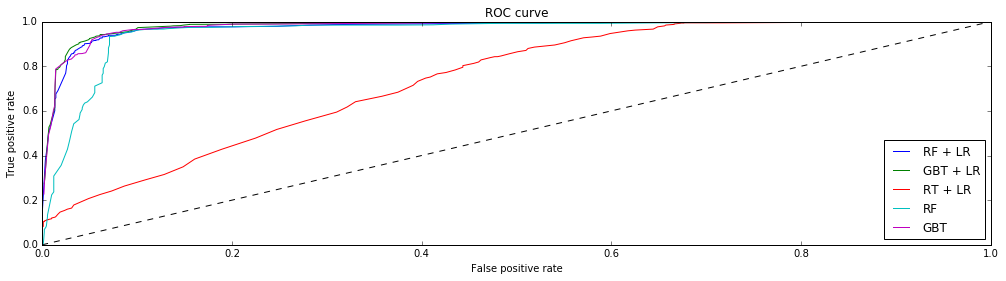

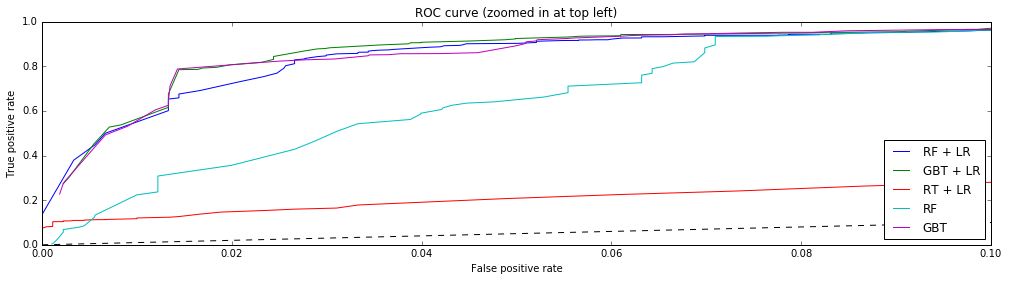

In [44]:
# ----------------------------------------------------
# Plot results
# ----------------------------------------------------

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
for key in roc_results.keys():
    plt.plot(roc_results.get(key)[0], roc_results.get(key)[1], label=key)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


plt.figure(2)
plt.xlim(0, 0.1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], 'k--')
for key in roc_results.keys():
    plt.plot(roc_results.get(key)[0], roc_results.get(key)[1], label=key)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [45]:
# Get the minimum threshold needed for the FPR_TARGET
def get_thresh_min(name, fpr_results, thresh_standard):
    fpr_mean = np.mean(fpr_results.get(name), axis=0)
    fpr_var  = np.std(fpr_results.get(name), axis=0)
    fpr_lb   = fpr_mean + 1.96*fpr_var                     # fpr lower bound CI
    thresh_min = min(thresh_standard[fpr_lb < FPR_TARGET]) # minimum threshold required to achieve FPR_TARGET
    return thresh_min



In [46]:
# ----------------------------------------------------
# Test models to predict 1's correctly. 
# Objective is to obtain the FPR_TARGET in the test data.
# We also still want to actually make some predictions.
# ----------------------------------------------------

# Get thresholds for each algorithm
for key in fpr_results.keys():
    thresh_min_results[key] = get_thresh_min(key, fpr_results, thresh_standard)
    
# Train with all training data and predict on testing data
_, _, y_preds = classification_models(y_train, X_train, y_test, X_test, 
                                                      [], [], thresh_standard, False)

# Get prediction accuracy
for key in thresh_min_results.keys():
    print '\n',key
    preds = y_test[y_preds.get(key) > thresh_min_results.get(key)]
    if len(preds) == 0: print 'no predictions :('
    else: print 'Accuracy:', np.mean(preds), 'Number: ', len(preds) 


RF + LR
Accuracy: 0.984790874525 Number:  263

GBT + LR
Accuracy: 0.987138263666 Number:  311

RT + LR
Accuracy: 1.0 Number:  55

RF
Accuracy: 1.0 Number:  32

GBT
Accuracy: 1.0 Number:  8


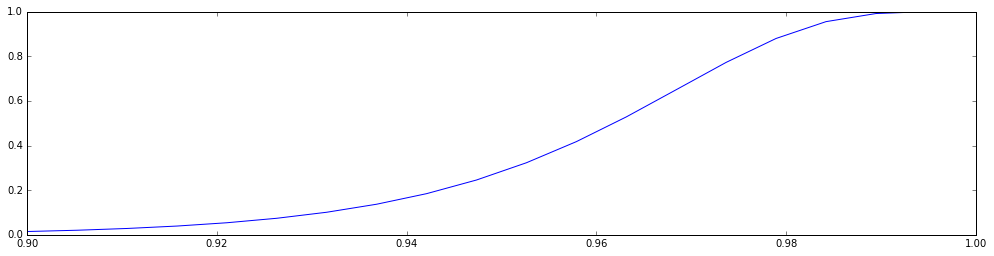

In [24]:
# Basic probability of our success (this is conservative since it assumes we ONLY have 57 games, i.e. we can't restart) 
tpr_system = np.linspace(0.9, 1.0, 20)
accts = 6
games = 57
success = 1 - (1- (tpr_system**games))**accts
plt.plot(tpr_system, success)